In [0]:
import pandas as pd
from  sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa 
import librosa.display as dis
import os
import matplotlib.pyplot as plt
import glob
import numpy as np




In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HEART DATA /heartbeat-sounds/set_b.csv')
print(df['label'].value_counts())

normal        320
murmur         95
extrastole     46
Name: label, dtype: int64


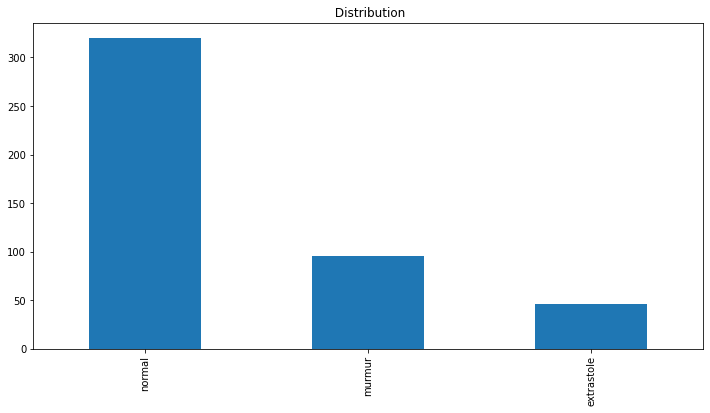

In [0]:
plt.figure(figsize = (12,6))
df['label'].value_counts().plot(kind = 'bar' , title = ' Distribution' )
plt.show()

In [0]:
train , test = train_test_split(df, test_size = 0.2 , random_state = 30)

print(len(train))
print(len(test))

323
81


**WE WILL CREATE OUR OWN DATASET**

In [0]:
#NOw creating our own  Dataset

df = []

for folder in ["/content/drive/My Drive/Colab Notebooks/HEART DATA /heartbeat-sounds/set_a/**",
               "/content/drive/My Drive/Colab Notebooks/HEART DATA /heartbeat-sounds/set_b/**"]:
  for fname in glob.iglob(folder):
    if os.path.exists(fname):
      label = os.path.basename(fname).split("_")[0]
      if librosa.get_duration(filename=fname)>=4:
        if label not in ["Aunlabelledtest","Bunlabelledtest"]:
          df.append(
              {
                  "filename " : fname,
               "label" : label 
              })
data=pd.DataFrame(df)
data.head()

,filename,label
0,/content/drive/My Drive/Colab Notebooks/HEART ...,artifact
1,/content/drive/My Drive/Colab Notebooks/HEART ...,artifact
2,/content/drive/My Drive/Colab Notebooks/HEART ...,artifact
3,/content/drive/My Drive/Colab Notebooks/HEART ...,artifact
4,/content/drive/My Drive/Colab Notebooks/HEART ...,artifact


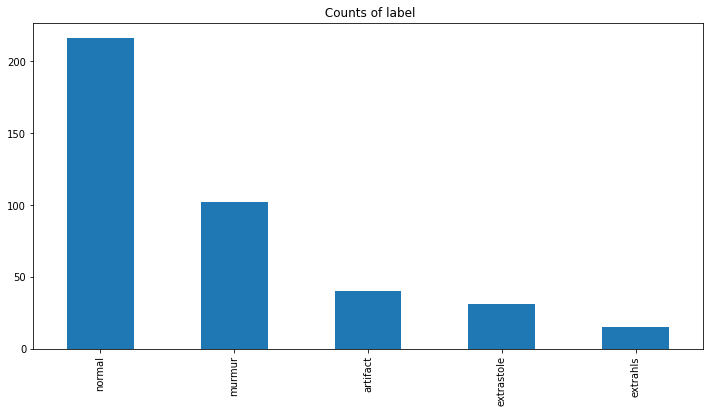

In [0]:
plt.figure(figsize=(12,6))
data['label'].value_counts().plot(kind = "bar" , title = " Counts of label")
plt.show()

In [0]:
from sklearn.utils import shuffle
data =shuffle(data, random_state =40)
data.head()

,filename,label
28,/content/drive/My Drive/Colab Notebooks/HEART ...,artifact
386,/content/drive/My Drive/Colab Notebooks/HEART ...,normal
195,/content/drive/My Drive/Colab Notebooks/HEART ...,murmur
44,/content/drive/My Drive/Colab Notebooks/HEART ...,extrahls
333,/content/drive/My Drive/Colab Notebooks/HEART ...,normal


**FEATURE ENGINEERING**

In [0]:
def features(path):

  f,samp_rate = librosa.load(path=path , duration=4)
  mfccs = librosa.feature.mfcc(y=f,sr=samp_rate,n_mfcc=50)
  return mfccs

In [0]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

print("Train: ", len(train))
print("Test: ", len(test))

Train:  323
Test:  81


In [0]:
test.head()

,filename,label
116,/content/drive/My Drive/Colab Notebooks/HEART ...,normal
288,/content/drive/My Drive/Colab Notebooks/HEART ...,normal
217,/content/drive/My Drive/Colab Notebooks/HEART ...,normal
39,/content/drive/My Drive/Colab Notebooks/HEART ...,artifact
277,/content/drive/My Drive/Colab Notebooks/HEART ...,normal


In [0]:
xtest=[]
xtrain = []
train = data.rename(columns={'filename ': 'filename'})
test = test.rename(columns={'filename ': 'filename'})

for i in range(len(train)):
  xtrain.append(features(train.filename.iloc[i]))
for i in range(len(test)):

  xtest.append(features(test["filename"].iloc[i]))
    

xtest=np.asarray(xtest)
xtrain = np.asarray(xtrain)

print(xtest.shape)
print(xtrain.shape)

(81, 50, 173)
(404, 50, 173)


**MFCC**

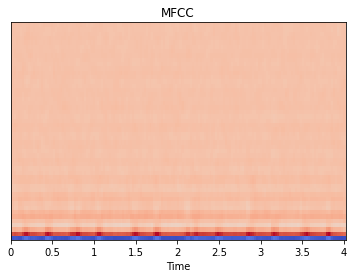

In [0]:
librosa.display.specshow(xtrain[0],x_axis='time')
plt.title("MFCC")
plt.show()

**LABEL ENCODING**

In [0]:
encoder = LabelEncoder()
encoder.fit(train.label)

ytrain = encoder.transform(train.label)
ytest = encoder.transform(test.label)
encoder.classes_

array(['artifact', 'extrahls', 'extrastole', 'murmur', 'normal'],
      dtype=object)

In [0]:
from keras.utils import to_categorical
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)
ytest.shape

Using TensorFlow backend.


(81, 5)

In [0]:
xtrain.shape

(404, 50, 173)

In [0]:
xtrain =xtrain.reshape(xtrain.shape[0],xtrain.shape[1],xtrain.shape[2],1)

xtest =xtest.reshape(xtest.shape[0],xtest.shape[1],xtest.shape[2],1)

xtrain.shape

(404, 50, 173, 1)

**DEEP LEARNING MODEL**

In [0]:
import keras
from keras.layers import Conv2D,Convolution2D,Flatten,Dense,Dropout,MaxPooling2D,GlobalAveragePooling2D
from keras.models import Sequential
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(xtrain.shape[0],xtrain.shape[1],xtrain.shape[2]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 403, 49, 16)       11088     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 201, 24, 16)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 201, 24, 16)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 200, 23, 32)       2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 11, 32)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 11, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 99, 10, 64)       

In [0]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(xtrain, ytrain,
              batch_size=60,
              epochs=400,
              validation_data=(xtest, ytest),
              shuffle=True
            )

ValueError: ignored

In [0]:
scores = model.evaluate(xtest, ytest, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1]*100)

81/81 [==============================] - 0s 3ms/step
Test loss: 0.02641774733539349
Test accuracy: 100.0


**Accuracy is 97 percent and without using Validation model get accuracy of 95% on Test Data, so therefore 95% accuracy is fine for classification**

In [0]:
x = features('/content/drive/My Drive/Colab Notebooks/HEART DATA /heartbeat-sounds/set_a/murmur__201108222232.wav')
x=x.reshape(1,x.shape[0],x.shape[1],1)
predictions = model.predict(x)
print(encoder.classes_)
print(predictions)   

['artifact' 'extrahls' 'extrastole' 'murmur' 'normal']
[[1.2688253e-13 1.5058859e-16 5.1938773e-14 1.0000000e+00 2.1008713e-10]]


In [0]:
x = features('/content/drive/My Drive/Colab Notebooks/HEART DATA /heartbeat-sounds/set_b/murmur_noisymurmur_135_1306428972976_A.wav')
x=x.reshape(1,x.shape[0],x.shape[1],1)
predictions = model.predict(x)
print(encoder.classes_)
print(predictions)  

['artifact' 'extrahls' 'extrastole' 'murmur' 'normal']
[[1.7529317e-08 2.9144104e-10 3.6917226e-03 9.9478662e-01 1.5216517e-03]]


In [0]:
x = features('/content/drive/My Drive/Colab Notebooks/HEART DATA /heartbeat-sounds/set_b/normal__107_1305654946865_C1.wav')
x=x.reshape(1,x.shape[0],x.shape[1],1)
predictions = model.predict_proba(x)
print(encoder.classes_)
print(predictions)  

['artifact' 'extrahls' 'extrastole' 'murmur' 'normal']
[[1.0826898e-07 2.0753018e-06 1.1485045e-01 6.2640705e-03 8.7888330e-01]]


**CHECKING OVERFITTING**

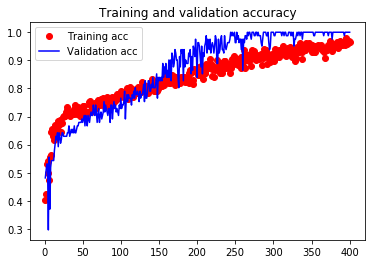

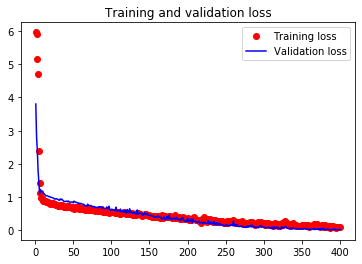

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', color='red',label='Training acc')
plt.plot(epochs, val_acc, 'b',color='blue', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo',color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b',color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
predIdxs = model.predict(xtest, batch_size=60)
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(ytest.argmax(axis=1), predIdxs,
	target_names=encoder.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

NameError: ignored